In [2]:
from tests.end_to_end.dexter.dexter import Dexter
from pymich.michelson_types import Nat, Address, Mutez, Int, Timestamp, Operations
from pymich.stdlib import Tezos

from copy import deepcopy

import pandas as pd

# Decentralized exchanges

## Initialization

Let's investigate how an automated market maker using the constant product formula behaves as we exchange from one side to the other!

Let's initialize our decentralized exchange with `token_pool = xtz_pool = lqt_total = 100 xtz`:

In [3]:
token_pool = 1000
xtz_pool = 1000

dex = Dexter(
    token_pool=Nat(token_pool),
    xtz_pool=Mutez(xtz_pool),
    lqt_total=Nat(1000),
    token_address=Address("KTtoken"),
    lqt_address=Address("KTlqt"),
    curve_id=Nat(0),
)

## Swapping XTZ for tokens

### Constant product

Let's graph what happens, when both pools are both 100 tokens large, and we trade in anything between 0 tokens and 1000 tokens. How many tokens do you get out. We iterating over an dex object copy to maintain the same initial conditions accross iterations, and record pool sizes and XTZ output:

In [4]:
conversions = []
pools = []
Tezos.amount = Mutez(0)


for xtz_in_value in range(0, 3 * dex.token_pool.value):
    Tezos.amount = Mutez(xtz_in_value)
    tmp_dex = deepcopy(dex)
    tmp_dex.xtz_to_token(
        to=Address("tzBob"),
        min_tokens_bought=Nat(0),
        deadline=Timestamp.now() + Int(10),
    )
    conversions.append([Tezos.amount.amount, tmp_dex.ops._Operations__list[0][2].value.value])
    pools.append([tmp_dex.xtz_pool.amount, tmp_dex.token_pool.value])

Graphing the trades show an asymptotical behavior. I can trade in as much as I want into a pool propgressively getting a worse exchange rate the amount I want to trade grows. This line tends to the amount that is in the XTZ pool at the moment of the trade.

<AxesSubplot:xlabel='xtz_in'>

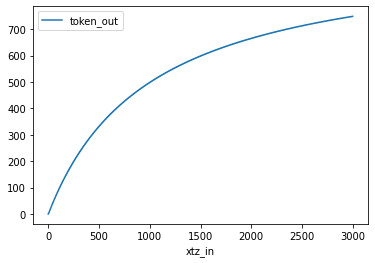

In [5]:
df_conversions = pd.DataFrame(conversions, columns=["xtz_in", "token_out"])
df_conversions.plot(x="xtz_in", y="token_out")

The constant product formula can be recovered by plotting the size of the pools as the trade grow. We notice the expected hyperbola, slighly asymetrical due to trading fees:

<AxesSubplot:xlabel='xtz_pool'>

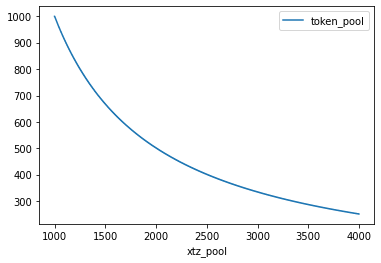

In [6]:
df_pools = pd.DataFrame(pools, columns=["xtz_pool", "token_pool"])
df_pools.plot(x="xtz_pool", y="token_pool")

### Flat curve

We reproduce the experiment by calling the `xtz_to_token` entrypoint this time:

In [8]:
dex = Dexter(
    token_pool=Nat(token_pool),
    xtz_pool=Mutez(xtz_pool),
    lqt_total=Nat(1000),
    token_address=Address("KTtoken"),
    lqt_address=Address("KTlqt"),
    curve_id=Nat(1),
)

conversions = []
pools = []
dex.ops = Operations()
for xtz_in_value in range(0, 3 * dex.token_pool.value):
    Tezos.amount = Mutez(xtz_in_value)
    tmp_dex = deepcopy(dex)
    tmp_dex.xtz_to_token(
        to=Address("tzBob"),
        min_tokens_bought=Nat(0),
        deadline=Timestamp.now() + Int(10),
    )
    conversions.append([Tezos.amount.amount, tmp_dex.ops._Operations__list[0][2].value.value])
    pools.append([tmp_dex.xtz_pool.amount, tmp_dex.token_pool.value])

We have the same assymptotical behavior, this time tending to the amount in the token pool at the time of the trade.

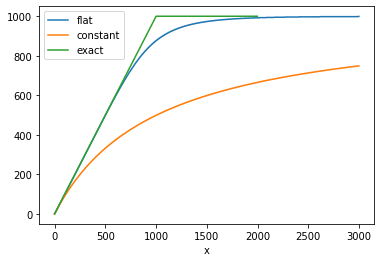

In [9]:
df = pd.DataFrame(conversions, columns=["xtz_in", "token_out"])
ax = df.plot(x="xtz_in", y="token_out")
df_conversions.plot(x="xtz_in", y="token_out", ax=ax)

xs = [[i, i * xtz_pool / token_pool] for i in range(token_pool * token_pool // xtz_pool)]
xs += [[token_pool + i, token_pool] for i in range(xtz_pool)]
straight_df = pd.DataFrame(xs, columns=["x", "y"])
straight_df.plot(x="x", y="y", ax=ax)
ax.legend(["flat", "constant", "exact"])

Plotting the pools also reveal the constant product formula, slightly asymetrical due to tradding fees:

<AxesSubplot:xlabel='token_pool'>

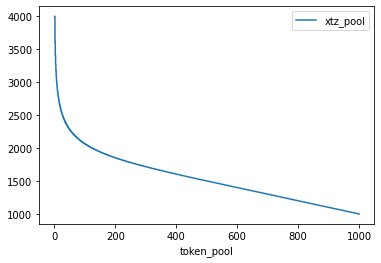

In [10]:
df_pools = pd.DataFrame(pools, columns=["xtz_pool", "token_pool"])
df_pools.plot(x="token_pool", y="xtz_pool")

## Swaping tokens for XTZ

### Constant product

### Flat curve